# Table of Contents
* ##  General Exploratory Data Analysis

* ##  Preprocessing of the Tasks
    - Sliding days as 1D Tempreture Arrays to predict next day's Temperature (SDT)
    - Sliding windows with multiple columns to predict next day's Temperature [Done] (SWT)
    - Sliding windows with multiple columns to predict next day's Daily Summary (SWS) [Done]


* ##  Machine Learning Models
    - Random Forest Regression [Done] (RF)
    - Linear Regression (LR)
    - XGBoost (XG) [Done-Bad]


* ##  Evaluation and understanding predictions with XAI tools
    - Lime
    - Lime for Time
    - SHAP [Done]

## General Exploratory Data Analysis

*Starting with importing the required libraries*

In [1]:
import numpy as np
import pandas as pd
import os
import shap
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
import lime
import lime.lime_tabular
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, accuracy_score
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.linear_model import Ridge
shap.initjs()

*Then continue by Exploring the dataset*

In [2]:
data = pd.read_csv("/kaggle/input/szeged-weather/weatherHistory.csv")
data.describe()
# Note: The column named "Loud Cover" is not making any sense as it is only "0" I will drop it during Preprocessing.

Temperature (C)  Apparent Temperature (C)      Humidity  \
count     96453.000000              96453.000000  96453.000000   
mean         11.932678                 10.855029      0.734899   
std           9.551546                 10.696847      0.195473   
min         -21.822222                -27.716667      0.000000   
25%           4.688889                  2.311111      0.600000   
50%          12.000000                 12.000000      0.780000   
75%          18.838889                 18.838889      0.890000   
max          39.905556                 39.344444      1.000000   

       Wind Speed (km/h)  Wind Bearing (degrees)  Visibility (km)  Loud Cover  \
count       96453.000000            96453.000000     96453.000000     96453.0   
mean           10.810640              187.509232        10.347325         0.0   
std             6.913571              107.383428         4.192123         0.0   
min             0.000000                0.000000         0.000000         0.0   
25%             5.828200              116.000000         8.339800         0.0   
50%             9.965900              180.000000        10.046400         0.0   
75%            14.135800              290.000000        14.812000         0.0   
max            63.852600              359.000000        16.100000         0.0   

       Pressure (millibars)  
count          96453.000000  
mean            1003.235956  
std              116.969906  
min                0.000000  
25%             1011.900000  
50%             1016.450000  
75%             1021.090000  
max             1046.380000

In [3]:
data.info()
# Note: The data does not require any imputing or interpolation as it has no null rows at all.
# Note: Most of useful columns are numeric, no need to overthink about encoding as some task won't require any.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96453 entries, 0 to 96452
Data columns (total 12 columns):
Formatted Date              96453 non-null object
Summary                     96453 non-null object
Precip Type                 95936 non-null object
Temperature (C)             96453 non-null float64
Apparent Temperature (C)    96453 non-null float64
Humidity                    96453 non-null float64
Wind Speed (km/h)           96453 non-null float64
Wind Bearing (degrees)      96453 non-null float64
Visibility (km)             96453 non-null float64
Loud Cover                  96453 non-null float64
Pressure (millibars)        96453 non-null float64
Daily Summary               96453 non-null object
dtypes: float64(8), object(4)
memory usage: 8.8+ MB


In [4]:
data.head(3)
# Note: the Dataset is designed to be "Hourly". This is good in terms of details, but I rather something less complex. So, I will change it to "Daily" on next steps.

Formatted Date        Summary Precip Type  Temperature (C)  \
0  2006-04-01 00:00:00.000 +0200  Partly Cloudy        rain         9.472222   
1  2006-04-01 01:00:00.000 +0200  Partly Cloudy        rain         9.355556   
2  2006-04-01 02:00:00.000 +0200  Mostly Cloudy        rain         9.377778   

   Apparent Temperature (C)  Humidity  Wind Speed (km/h)  \
0                  7.388889      0.89            14.1197   
1                  7.227778      0.86            14.2646   
2                  9.377778      0.89             3.9284   

   Wind Bearing (degrees)  Visibility (km)  Loud Cover  Pressure (millibars)  \
0                   251.0          15.8263         0.0               1015.13   
1                   259.0          15.8263         0.0               1015.63   
2                   204.0          14.9569         0.0               1015.94   

                       Daily Summary  
0  Partly cloudy throughout the day.  
1  Partly cloudy throughout the day.  
2  Partly cloudy throughout the day.

## Preprocessing of the Tasks

we need to simplify the summaries as there are too many details we don't need. I wil do it with a custom function.

In [5]:
def simplify_summaries(base_summary):
    base_split = base_summary.split(" ")
    removals_list = ["Light","Dangerously","Partly","Mostly","and"]
    to_be_replaced_list = ["Breezy","Drizzle","Overcast"]
    replacement_list = ["Windy","Rain","Cloudy"]
    for removal in removals_list: 
        if removal in base_split:
            base_split.remove(removal)
            
    for i in range(len(to_be_replaced_list)):
        if to_be_replaced_list[i] in base_split:
            base_split.remove(to_be_replaced_list[i])
            base_split.append(replacement_list[i])
        
    base_split.sort()
    return " ".join(base_split)

In [6]:
data.Summary = data.Summary.apply(simplify_summaries)
data.head(3)
# much better now as we reduced complexity of it dramatically.

Formatted Date Summary Precip Type  Temperature (C)  \
0  2006-04-01 00:00:00.000 +0200  Cloudy        rain         9.472222   
1  2006-04-01 01:00:00.000 +0200  Cloudy        rain         9.355556   
2  2006-04-01 02:00:00.000 +0200  Cloudy        rain         9.377778   

   Apparent Temperature (C)  Humidity  Wind Speed (km/h)  \
0                  7.388889      0.89            14.1197   
1                  7.227778      0.86            14.2646   
2                  9.377778      0.89             3.9284   

   Wind Bearing (degrees)  Visibility (km)  Loud Cover  Pressure (millibars)  \
0                   251.0          15.8263         0.0               1015.13   
1                   259.0          15.8263         0.0               1015.63   
2                   204.0          14.9569         0.0               1015.94   

                       Daily Summary  
0  Partly cloudy throughout the day.  
1  Partly cloudy throughout the day.  
2  Partly cloudy throughout the day.

In [7]:
# Dropping the column named "Loud Cover" on general dataset "data"
data.drop(columns=["Loud Cover"], inplace=True)

In [8]:
# Changing the original "Hourly" dataset to new and simpler "Daily"
# Fixing the Formatted Date for pandas usage.
data['Formatted Date'] = pd.to_datetime(data['Formatted Date'], utc=True)
data.sort_values(by=['Formatted Date'], inplace=True, ascending=True)

## Sliding windows with multiple columns to predict next day's Temperature (SWT)

In [9]:
data.head(4)

Formatted Date Summary Precip Type  Temperature (C)  \
2880 2005-12-31 23:00:00+00:00  Cloudy        rain         0.577778   
2881 2006-01-01 00:00:00+00:00  Cloudy        rain         1.161111   
2882 2006-01-01 01:00:00+00:00  Cloudy        rain         1.666667   
2883 2006-01-01 02:00:00+00:00  Cloudy        rain         1.711111   

      Apparent Temperature (C)  Humidity  Wind Speed (km/h)  \
2880                 -4.050000      0.89            17.1143   
2881                 -3.238889      0.85            16.6152   
2882                 -3.155556      0.82            20.2538   
2883                 -2.194444      0.82            14.4900   

      Wind Bearing (degrees)  Visibility (km)  Pressure (millibars)  \
2880                   140.0           9.9820               1016.66   
2881                   139.0           9.9015               1016.15   
2882                   140.0           9.9015               1015.87   
2883                   140.0           9.9015               1015.56   

                          Daily Summary  
2880  Mostly cloudy throughout the day.  
2881  Mostly cloudy throughout the day.  
2882  Mostly cloudy throughout the day.  
2883  Mostly cloudy throughout the day.

In [10]:
# Grouping by days to achieve "Daily" dataset on what's left as numerical columns for "Sliding Windows to predict Temp" task. 
swt_data = data.groupby([data['Formatted Date'].dt.date]).mean()
swt_data["Summary"] = data["Summary"].groupby([data['Formatted Date'].dt.date]).agg(lambda x:x.value_counts().index[0])
le = LabelEncoder()
swt_data.Summary = le.fit_transform(swt_data.Summary)

In [11]:
# Results are sorted and daily.
swt_data.head() 

Temperature (C)  Apparent Temperature (C)  Humidity  \
Formatted Date                                                        
2005-12-31             0.577778                 -4.050000  0.890000   
2006-01-01             4.075000                 -0.174537  0.817083   
2006-01-02             5.263194                  1.808796  0.847083   
2006-01-03             2.340509                  0.445370  0.897083   
2006-01-04             2.251852                 -0.663194  0.906667   

                Wind Speed (km/h)  Wind Bearing (degrees)  Visibility (km)  \
Formatted Date                                                               
2005-12-31              17.114300              140.000000         9.982000   
2006-01-01              21.229192              142.750000        11.348487   
2006-01-02              17.824713              164.583333         8.492079   
2006-01-03               7.726658              252.541667         9.223958   
2006-01-04              12.152817               35.000000         8.352546   

                Pressure (millibars)  Summary  
Formatted Date                                 
2005-12-31               1016.660000        1  
2006-01-01               1011.985000        1  
2006-01-02               1010.384167        1  
2006-01-03               1021.170833        1  
2006-01-04                981.770833        1

In [12]:
# Checking the results and it is clearly worked.
swt_data.describe()

Temperature (C)  Apparent Temperature (C)     Humidity  \
count      4019.000000               4019.000000  4019.000000   
mean         11.927112                 10.848281     0.734940   
std           8.787951                  9.939594     0.134981   
min         -15.958796                -18.825463     0.297500   
25%           5.038310                  2.769213     0.632083   
50%          12.174074                 11.846296     0.744167   
75%          19.186690                 19.180440     0.842500   
max          30.814352                 30.034028     0.995000   

       Wind Speed (km/h)  Wind Bearing (degrees)  Visibility (km)  \
count        4019.000000             4019.000000      4019.000000   
mean           10.813734              187.488224        10.347299   
std             5.001659               67.285953         3.212268   
min             1.110900                7.708333         0.000000   
25%             7.233260              141.229167         8.877808   
50%             9.926321              183.583333        11.312263   
75%            13.364677              237.604167        12.072317   
max            37.929588              336.416667        15.924913   

       Pressure (millibars)      Summary  
count           4019.000000  4019.000000  
mean            1003.236631     1.055238  
std               71.232784     0.523166  
min              336.542500     0.000000  
25%             1010.817292     1.000000  
50%             1015.989167     1.000000  
75%             1020.556667     1.000000  
max             1043.532083     6.000000

Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()


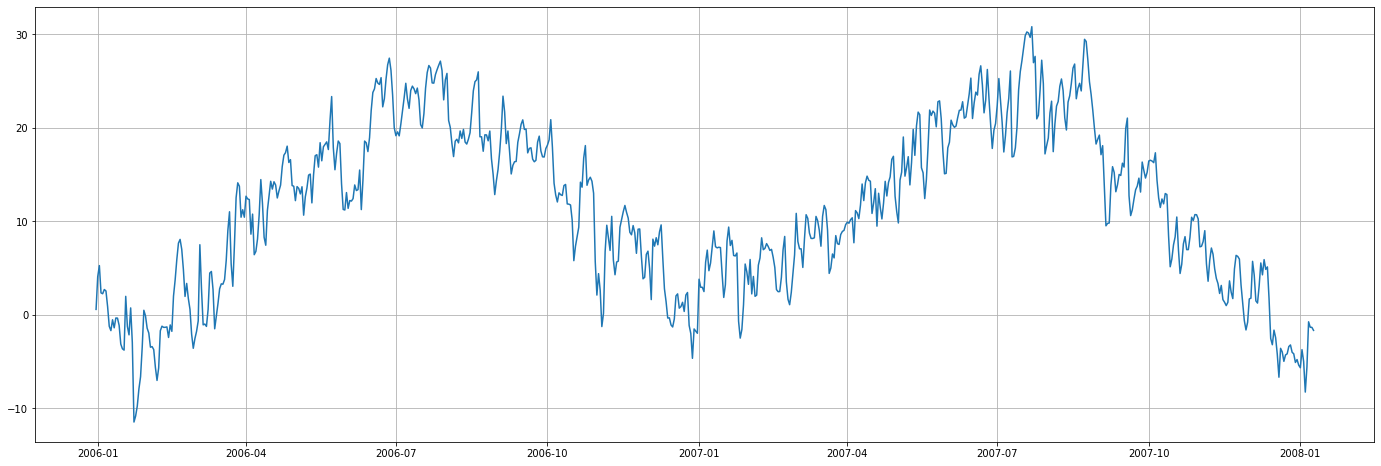

In [13]:
# Plotting approx. 2 years to have an idea about what we are working with.
plt.figure(figsize=(24,8))
plt.plot(swt_data["Temperature (C)"][:740])
plt.grid()
plt.show()

We see that there are a lot of spikes everywhere on the plot. This would increase complexity. <br>
So, I decided to apply rolling mean to reduce spikes.

In [14]:
ROLLING_MEAN_PARAMETER = 3
swt_data[["Temperature (C)","Apparent Temperature (C)","Humidity","Wind Speed (km/h)", "Wind Bearing (degrees)", "Visibility (km)", "Pressure (millibars)"]] = np.round(swt_data[["Temperature (C)","Apparent Temperature (C)","Humidity","Wind Speed (km/h)", "Wind Bearing (degrees)", "Visibility (km)", "Pressure (millibars)"]].rolling(ROLLING_MEAN_PARAMETER).mean(),3)
swt_data.dropna(inplace=True) # dropping the null days that are created by rolling mean

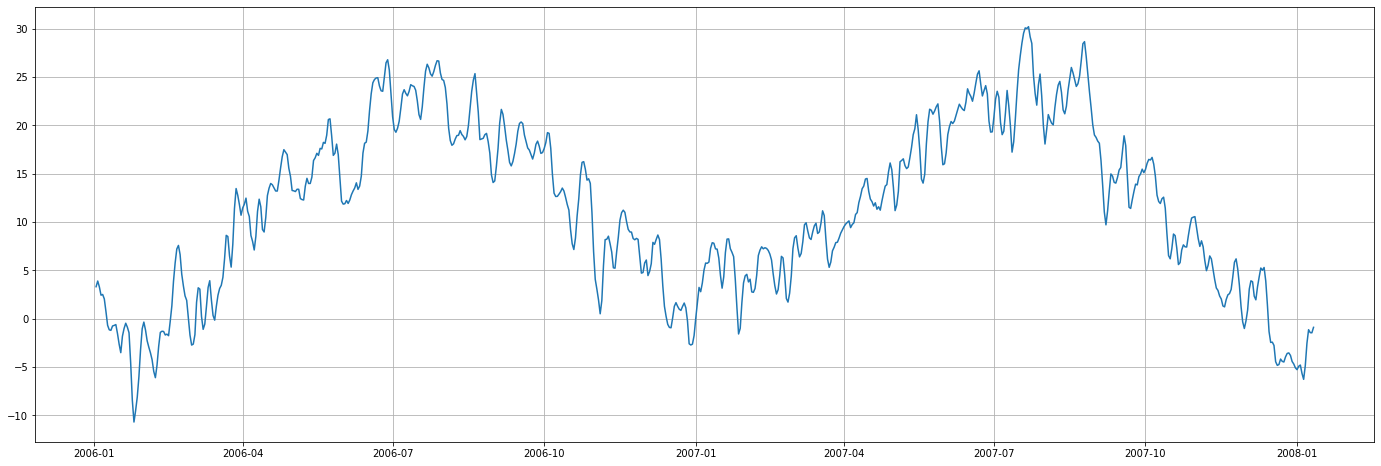

In [15]:
# Plotting approx. 2 years to have an idea about what we are working with after rolling mean
plt.figure(figsize=(24,8))
plt.plot(swt_data["Temperature (C)"][:740])
plt.grid()
plt.show()

As we see above, spikes are reduced dramatically. Therefore, it is much easier to learn a statistical model.

In [16]:
# Now I will design the dataset into more trainable sliding windows format.
N_DAYS_BEFORE = 5
swt_train = pd.DataFrame()

for day in range(N_DAYS_BEFORE-1,len(swt_data)):
    for i in reversed(range(1,N_DAYS_BEFORE)):
        for j in swt_data.columns:
            col_name = str(j) + " - " + str(i)
            swt_train.loc[day, col_name] = (swt_data[j][day-i])

In [17]:
# each row consist from previous 5 days with details.
swt_train.head()

Temperature (C) - 4  Apparent Temperature (C) - 4  Humidity - 4  \
4                3.305                        -0.805         0.851   
5                3.893                         0.693         0.854   
6                3.285                         0.530         0.884   
7                2.432                         0.076         0.918   
8                2.502                         0.338         0.935   

   Wind Speed (km/h) - 4  Wind Bearing (degrees) - 4  Visibility (km) - 4  \
4                 18.723                     149.111                9.941   
5                 15.594                     186.625                9.688   
6                 12.568                     150.708                8.690   
7                  9.624                     142.472                7.295   
8                  8.958                     148.125                5.765   

   Pressure (millibars) - 4  Summary - 4  Temperature (C) - 3  \
4                  1013.010          1.0                3.893   
5                  1014.513          1.0                3.285   
6                  1004.442          1.0                2.432   
7                   979.605          1.0                2.502   
8                   980.430          1.0                2.044   

   Apparent Temperature (C) - 3  ...  Pressure (millibars) - 2  Summary - 2  \
4                         0.693  ...                  1004.442          1.0   
5                         0.530  ...                   979.605          1.0   
6                         0.076  ...                   980.430          1.0   
7                         0.338  ...                   996.581          1.0   
8                         0.309  ...                  1029.784          0.0   

   Temperature (C) - 1  Apparent Temperature (C) - 1  Humidity - 1  \
4                2.432                         0.076         0.918   
5                2.502                         0.338         0.935   
6                2.044                         0.309         0.944   
7                0.732                        -0.775         0.917   
8               -0.683                        -2.132         0.866   

   Wind Speed (km/h) - 1  Wind Bearing (degrees) - 1  Visibility (km) - 1  \
4                  9.624                     142.472                7.295   
5                  8.958                     148.125                5.765   
6                  7.103                     170.472                4.510   
7                  5.906                     161.819                5.972   
8                  5.700                     145.736                7.391   

   Pressure (millibars) - 1  Summary - 1  
4                   979.605          1.0  
5                   980.430          1.0  
6                   996.581          1.0  
7                  1029.784          0.0  
8                  1033.416          1.0  

[5 rows x 32 columns]

In [18]:
# first part of the shapes must be the same to labels.
print(swt_train.shape)

(4013, 32)


In [19]:
# Prepearing the labels for SWT task
# ignoring the first 4 days to match training data & only getting values so we won't have issues with date index later on.
swt_labels = swt_data["Temperature (C)"][N_DAYS_BEFORE-1:].values
# first part of the shapes must be the same to train.
print(swt_labels.shape)

(4013,)


In [20]:
# Temperature (C) - 1  of 22th feature should be equal to the value of 23th label (today = tomorrow of yesterday)
print(" -- Features -- \n",swt_train.iloc[23])
print("\n -- Label -- \n", swt_labels[22])

 -- Features -- 
 Temperature (C) - 4              -10.693
Apparent Temperature (C) - 4     -14.088
Humidity - 4                       0.749
Wind Speed (km/h) - 4              8.332
Wind Bearing (degrees) - 4       122.611
Visibility (km) - 4               10.594
Pressure (millibars) - 4        1038.652
Summary - 4                        0.000
Temperature (C) - 3               -9.515
Apparent Temperature (C) - 3     -12.019
Humidity - 3                       0.758
Wind Speed (km/h) - 3              6.161
Wind Bearing (degrees) - 3       147.569
Visibility (km) - 3               10.094
Pressure (millibars) - 3        1035.109
Summary - 3                        1.000
Temperature (C) - 2               -8.113
Apparent Temperature (C) - 2     -10.827
Humidity - 2                       0.727
Wind Speed (km/h) - 2              6.720
Wind Bearing (degrees) - 2       116.931
Visibility (km) - 2                9.580
Pressure (millibars) - 2        1031.131
Summary - 2                        1.00

In [21]:
# Splitting train and test to be able to evaluate properly with some train test ratio.
swt_train_x, swt_test_x, swt_train_y, swt_test_y = train_test_split(swt_train,swt_labels, test_size=0.1)

In [22]:
# Checking the shapes for safety
print("shape of training dataset features: ",swt_train_x.shape)
print("shape of training dataset labels: ",swt_train_y.shape)
print("shape of testing dataset features: ",swt_test_x.shape)
print("shape of testing dataset labels: ",swt_test_y.shape)

shape of training dataset features:  (3611, 32)
shape of training dataset labels:  (3611,)
shape of testing dataset features:  (402, 32)
shape of testing dataset labels:  (402,)


## Sliding windows with multiple columns to predict next day's Daily Summary (SWS)

In [23]:
# Prepearing the labels for SWT task
# ignoring the first 4 days to match training data & only getting values so we won't have issues with date index later on.
sws_labels = swt_data["Summary"][N_DAYS_BEFORE-1:].values
# first part of the shapes must be the same to train.
print(sws_labels.shape)

(4013,)


In [24]:
# splitting (75/25) as usual
sws_train_x, sws_test_x, sws_train_y, sws_test_y = train_test_split(swt_train, sws_labels, random_state=41, test_size=0.25)

In [25]:
sws_train_x

Temperature (C) - 4  Apparent Temperature (C) - 4  Humidity - 4  \
1809               -0.378                        -5.105         0.840   
2607                3.539                         2.054         0.911   
929                22.055                        21.913         0.656   
1145               -0.809                        -5.169         0.849   
3707                6.847                         4.806         0.784   
...                   ...                           ...           ...   
325                10.999                        10.151         0.740   
1108               -8.337                       -10.063         0.833   
3984                3.842                         1.132         0.867   
935                21.955                        21.790         0.564   
1988               22.535                        22.614         0.687   

      Wind Speed (km/h) - 4  Wind Bearing (degrees) - 4  Visibility (km) - 4  \
1809                 18.131                     260.764               10.014   
2607                  6.741                     240.542                6.647   
929                  15.473                     218.944               11.914   
1145                 14.589                     296.972                8.657   
3707                 13.457                     225.556               12.937   
...                     ...                         ...                  ...   
325                  11.474                     159.625                9.336   
1108                  5.825                     196.431                4.105   
3984                 10.947                     166.833                8.327   
935                  11.555                     248.889               11.723   
1988                 15.871                     190.986               12.090   

      Pressure (millibars) - 4  Summary - 4  Temperature (C) - 3  \
1809                   986.471          1.0               -0.471   
2607                   836.496          1.0                2.315   
929                   1014.334          1.0               19.764   
1145                  1018.085          1.0               -0.742   
3707                  1018.425          1.0                8.938   
...                        ...          ...                  ...   
325                   1022.024          1.0               10.042   
1108                  1034.290          3.0               -8.554   
3984                  1019.156          1.0                3.692   
935                   1014.258          1.0               20.066   
1988                  1008.021          1.0               20.237   

      Apparent Temperature (C) - 3  ...  Pressure (millibars) - 2  \
1809                        -4.693  ...                   843.030   
2607                        -0.229  ...                   991.408   
929                         19.803  ...                  1016.619   
1145                        -5.394  ...                  1017.013   
3707                         7.568  ...                  1012.938   
...                            ...  ...                       ...   
325                          8.977  ...                   933.290   
1108                        -9.785  ...                  1038.316   
3984                         0.943  ...                  1019.219   
935                         19.935  ...                  1012.782   
1988                        20.293  ...                  1010.594   

      Summary - 2  Temperature (C) - 1  Apparent Temperature (C) - 1  \
1809          1.0               -2.320                        -6.417   
2607          1.0                1.769                        -0.995   
929           1.0               21.416                        21.343   
1145          1.0               -2.171                        -7.655   
3707          1.0                6.147                         4.148   
...           ...                  ...                           ...   
325           1.0 

In [26]:
# Checking the shapes for safety
print("shape of training dataset features: ",sws_train_x.shape)
print("shape of training dataset labels: ",sws_train_y.shape)
print("shape of testing dataset features: ",sws_test_x.shape)
print("shape of testing dataset labels: ",sws_test_y.shape)

shape of training dataset features:  (3009, 32)
shape of training dataset labels:  (3009,)
shape of testing dataset features:  (1004, 32)
shape of testing dataset labels:  (1004,)


## Sliding days as 1D Tempreture Arrays to predict next day's Temperature (SDT)

In [27]:
# For this approach I will only use 1 column. this will be the "Temperature (C)"
all_temps = swt_data["Temperature (C)"].values
train_temps = []
label_temps = []
for i in range(len(all_temps)-30):
    label_temps.append(all_temps[i+30])
    train_temps.append(all_temps[i:i+30])
    
train_temps = np.array(train_temps)
label_temps = np.array(label_temps)

In [28]:
# last of the tomorrow's array should be same as the today's label 
print(train_temps[45])
print(label_temps[44]) 

[-0.286  1.32   3.875  5.764  7.207  7.577  6.638  4.605  3.389  2.357
  1.898  0.087 -1.691 -2.733 -2.631 -1.655  1.689  3.196  3.056  0.228
 -1.103 -0.556  1.261  3.22   3.927  1.94   0.338 -0.153  1.271  2.432]
2.432


In [29]:
# Splitting the train and test 
sdt_train_x = train_temps[:-400]
sdt_test_x = train_temps[-400:]
sdt_train_y = label_temps[:-400]
sdt_test_y = label_temps[-400:]

In [30]:
# Checking the shapes for safety
print("shape of training dataset features: ",sdt_train_x.shape)
print("shape of training dataset labels: ",sdt_train_y.shape)
print("shape of testing dataset features: ",sdt_test_x.shape)
print("shape of testing dataset labels: ",sdt_test_y.shape)

shape of training dataset features:  (3587, 30)
shape of training dataset labels:  (3587,)
shape of testing dataset features:  (400, 30)
shape of testing dataset labels:  (400,)


## Machine Learning Models

* ### Random Forest Regressor

In [31]:
rf_model = RandomForestRegressor(max_depth=10)
rf_model.fit(swt_train_x,swt_train_y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=10, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

* ### XGBoost

In [32]:
dtrain = xgb.DMatrix(sws_train_x, label=sws_train_y)
dtest = xgb.DMatrix(sws_test_x, label=sws_test_y)
param = {'max_depth': 4, 'eta': 0.05, 'objective': 'multi:softmax'}
param['eval_metric'] = "mlogloss"
param['num_class'] = 14
num_round = 400
evallist = [(dtest, 'test')]
bst = xgb.train(param, dtrain, num_round, evallist, early_stopping_rounds=10)
#model performs well.

[0]	test-mlogloss:2.36029
Will train until test-mlogloss hasn't improved in 10 rounds.
[1]	test-mlogloss:2.15684
[2]	test-mlogloss:1.99591
[3]	test-mlogloss:1.86164
[4]	test-mlogloss:1.74688
[5]	test-mlogloss:1.64677
[6]	test-mlogloss:1.55902
[7]	test-mlogloss:1.48058
[8]	test-mlogloss:1.40969
[9]	test-mlogloss:1.34488
[10]	test-mlogloss:1.28558
[11]	test-mlogloss:1.23121
[12]	test-mlogloss:1.18136
[13]	test-mlogloss:1.13513
[14]	test-mlogloss:1.09221
[15]	test-mlogloss:1.05235
[16]	test-mlogloss:1.01517
[17]	test-mlogloss:0.98041
[18]	test-mlogloss:0.94818
[19]	test-mlogloss:0.91774
[20]	test-mlogloss:0.88935
[21]	test-mlogloss:0.86249
[22]	test-mlogloss:0.83757
[23]	test-mlogloss:0.81394
[24]	test-mlogloss:0.79158
[25]	test-mlogloss:0.77073
[26]	test-mlogloss:0.75048
[27]	test-mlogloss:0.73182
[28]	test-mlogloss:0.71377
[29]	test-mlogloss:0.69695
[30]	test-mlogloss:0.68142
[31]	test-mlogloss:0.66607
[32]	test-mlogloss:0.65184
[33]	test-mlogloss:0.63805
[34]	test-mlogloss:0.62495
[35]

* ### Ridge Regression

In [33]:
lr_model = Ridge()
lr_model.fit(sdt_train_x,sdt_train_y)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

## Evaluation and understanding predictions with XAI tools

* ### RF - SWT - SHAP

Here on this part of the notebook, the first explainable AI tool and it's use case will be demonstrated.

The tool is **SHAP**. <br />
To implement this tool for our time series explanation purposes, I will use my **RandomForestRegressor** model which was trained on the Sliding Windows styled dataframe with the Temperature label. <br />
Firstly, we can start by checking if the model is worth to explain or does it require more development. <br />
For this, I will be using r^2 score. The better r^2 score means better performance. <br />


In [34]:
swt_pred_y = rf_model.predict(swt_test_x)
print("r_square score of the RandomForestRegressor model : ",r2_score(swt_test_y,swt_pred_y))

r_square score of the RandomForestRegressor model :  0.9845155825788787


As we can see above, the model performs really good on the test data. <br /> 
So we shall continue with explaining.  <br />  <br /> <br /> 
To begin our explanation on this model and the task I want to use a simple bar representation of importance. <br />
Basically, this will sort the features by decreasing importance for our trained model and plot them.

### SHAP Feature Importance

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


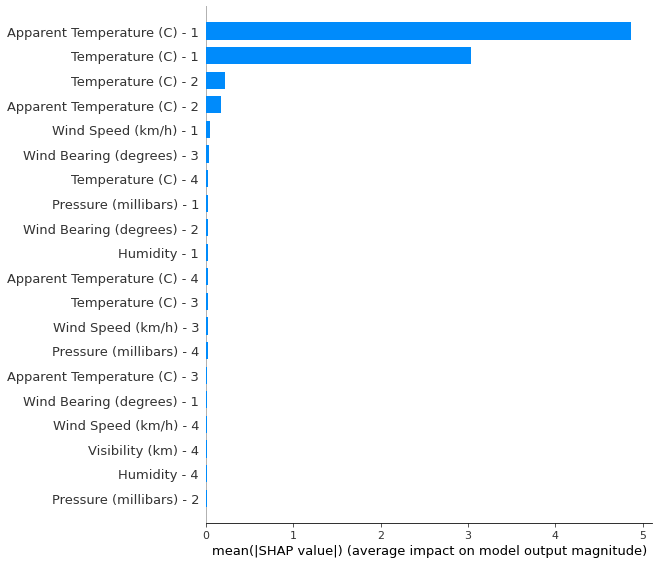

In [35]:
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(swt_train_x)

shap.summary_plot(shap_values, swt_train_x, plot_type="bar");

The chart above explains the average impact per given column on predictions. <br />
So, if we look at it we can say the biggest effect on the prediction (today's temperature) is yesterday's Temperature. <br />
That is follwed by: Apparent Temperature of yesterday, Temperature of the day before yesterday, Apparent Temperature of the day before yesterday.
<br /> <br /> <br />
Now that we know which columns are more important when it comes to do predictions with our model, we can now see how they were actually affecting the outputs. <br />
For this, I will use a typical summary plot. Which combines feature importance with feature effects in very visible way.
### SHAP Summary Plot

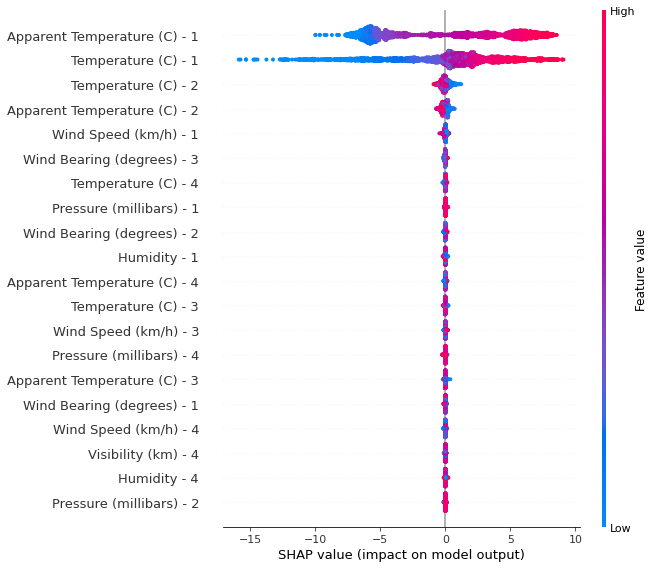

In [36]:
shap.summary_plot(shap_values, swt_train_x)

As we can see above, each point on the summary plot is a Shapley value for a feature and an instance. <br />
The position on the y-axis is determined by the feature and on the x-axis by the Shapley value. <br />
The color represents the value of the feature from low to high. <br />
Just like the previous plot, here features are ordered according to their importance. <br /> <br />
### SHAP Force Plot

In [37]:
a = shap.force_plot(explainer.expected_value, shap_values[100,:], swt_train_x.iloc[100,:])
display(a)

b = shap.force_plot(explainer.expected_value, shap_values[80,:], swt_train_x.iloc[80,:])
display(b)

c = shap.force_plot(explainer.expected_value, shap_values[70,:], swt_train_x.iloc[70,:])
display(c)

d = shap.force_plot(explainer.expected_value, shap_values[90,:], swt_train_x.iloc[90,:])
display(d)

As we can see above, I displayed force plots of predictions for the 4 different days. <br />
The most important things to pay attention here are:
* Model Output Value
* Base Value
* Forces that affect the Output value 
<br /> <br />
To begin with, the base value is the **average** output value for entire dataset. But as we can see, with the forces (affects of the values of some columns) the Model Output Value moves away from the base value. <br />
Now, we can take a look at the prediction instances above. <br /> 
At the last prediciton. We can see that the columns "Apparent Temperature(C)-1" and "Temperature(C)-1" columns increased the base value. Where the same columns for the day before applied forces to lower it. At the end prediction value become 15.83. <br /> <br /> <br /> 

Up next, is an interactive cluster of all predictions. The best part about this is that you can change the x-axis selection to have different force plots for different purposes <br /> 

### Clustered SHAP Values

In [38]:
shap.force_plot(explainer.expected_value, shap_values, swt_train_x)

shap.force_plot is slow for many thousands of rows, try subsampling your data.


To simply describe what we see above, we can say "a cummulative force plot graphs for all predictions". (This is also the reason of slowness). <br />
Go ahead and change the value on the left-hand side dropdown input if you want to experience interacitveness of the graph.

In [40]:
print("prediction : ",rf_model.predict(swt_test_x.iloc[77].values.reshape(1,32)))
print("ground truth : ",swt_test_y[77])
# very accurate prediction.

prediction :  [-7.35851849]
ground truth :  -7.256


* ### XG - SWS - LIME

In [ ]:
y_pred = bst.predict(dtest)
accuracy_score(y_pred, sws_test_y)

In [ ]:
#explainer = lime.lime_tabular.LimeTabularExplainer(dtrain, feature_names=sws_train_x.columns.values.tolist(), verbose=True, mode='regression')

#expXGB = explainer.explain_instance(sws_train_x, bst.predict)
#expXGB.show_in_notebook(show_table=True) 

* ### LR - SDT - SHAP

In [ ]:
sdt_pred_y = lr_model.predict(sdt_test_x)
print("r_square score of the Ridge Regression model : ",r2_score(sdt_test_y,sdt_pred_y))   # the model performs really good.

In [ ]:
plt.figure(figsize=(20,6))
plt.plot(sdt_pred_y)
plt.plot(sdt_test_y)
plt.tight_layout()

In [ ]:
# efe ergün